In [1]:
import pandas as pd
from datetime import datetime, date
import re
from pandas import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
trades = pd.read_csv('data/trades/ETHBTC-formatted_dates.csv')
trades['ExactTimeStamp'][1:10]

1    1521332236334
2    1521332236375
3    1521332236439
4    1521332236986
5    1521332236986
6    1521332237087
7    1521332237124
8    1521332237233
9    1521332237482
Name: ExactTimeStamp, dtype: int64

In [3]:
firstTime = trades['ExactTimeStamp'][0]
firstTimeAsDatetime = datetime.utcfromtimestamp(firstTime/1000.0);
N = np.size(trades['ExactTimeStamp'])
lastTime = trades['ExactTimeStamp'][N-1]
lastTimeAsDatetime = datetime.utcfromtimestamp(lastTime/1000.0);
print("First day "+ firstTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))
print("Last day " + lastTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))

First day 2018-03-18 00:17:16
Last day 2018-04-26 17:42:24


### Volatility of log returns:

$$
\begin{equation}
\sigma^2 = \frac{1}{N-1}\sum_{i=1}^N \frac{(x_i - \bar x)^2}{\Delta t_i}\,
\end{equation}
$$

where, $x_i = \ln\frac{S_i}{S_{i-1}}$ with $S_i$ the original prices, here $\bar x$ is mean of $(x_i)_i$ and $\Delta {t_i} = t_i - t_{i-1}$.

The "ExactTimeStamp" is milliseconds since last UNIX epoch.

In [4]:
print("Total samples before :", trades.shape[0])

#deleting the equal ExactTimeStamps to avoid delta_t = 0
trades.drop_duplicates('ExactTimeStamp', keep='first', inplace=True)

print("Total samples after :", trades.shape[0])

Total samples before : 4710672
Total samples after : 3144409


In [11]:
def logReturns(S):
    return np.log(S/S.shift(1));

# assumes times come as unix times i.e. number of seconds from a date in the past
def volFromTimeSeriesPerSecond(prices, timeStamps):
    if (np.size(prices)<= 2):
        raise ValueError('we need more prices than 2')
    x = logReturns(prices)[1:]; # the value at the first index is NaN
    xBar = np.mean(x);
    deltaT = (timeStamps - timeStamps.shift(1))[1:]; # the value at the first index is NaN
    deltaT = deltaT/1000.0;     
    N = np.size(x);
    return np.sqrt(sum((x-xBar)*(x-xBar)/deltaT)/(N-1));

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*np.sqrt(3600.0*24*365.25)


print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(trades['Price'], trades['ExactTimeStamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(trades['Price'], trades['ExactTimeStamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(trades['Price'], trades['ExactTimeStamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(trades['Price'], trades['ExactTimeStamp'])))


Vol is 0.30% per second
Vol is 17.71% per hour
Vol is 86.75% per day
Vol is 1657.98% per year


## Volatility per day:

In [59]:
trades.drop_duplicates('ExactTimeStamp', keep='first', inplace=True)

In [60]:
dates = trades.TimeStamp.unique().tolist()

In [61]:
grouped = trades.set_index(['TimeStamp'])

In [62]:
grouped['DailyVol'] = 0
for date in dates:
    grouped.loc[date, 'DailyVol'] = volFromTimeSeriesPerSecond(grouped.loc[date, 'Price'], grouped.loc[date, 'ExactTimeStamp'])

In [ ]:
grouped.reset_index(inplace=True)
grouped.TimeStamp = pd.to_datetime(grouped.TimeStamp)

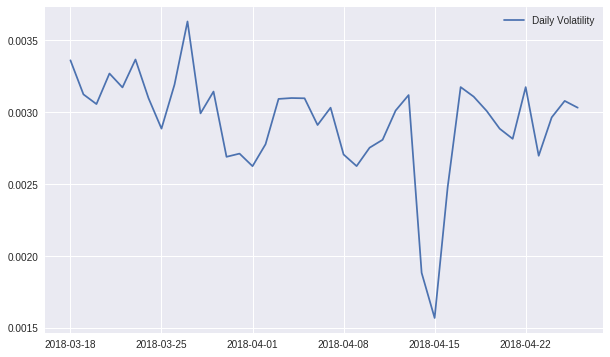

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(grouped.TimeStamp, grouped.DailyVol, label='Daily Volatility')
plt.legend()